In [1]:
import utm
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
from shapely.geometry import Point
from itertools import combinations
from haversine import haversine, Unit
from sklearn.neighbors import BallTree
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import haversine_distances

In [53]:
#def haversine(point1, point2):
#    return haversine_distances([point1, point2]).item(0)

def haversine_distance(point1, point2):
    return haversine((point1.y, point1.x), (point2.y, point2.x), unit=Unit.METERS)

def equirectangular_approximation(point1, point2):
    # point: point[0] == latitud, point[2] == longitud
    # radius of the earth in km (mean value)
    R = 6371.0088
    # restar longitudes y multiplicar por el coseno de la suma de las latitudes
    x = (point2[1] - point1[1]) * np.cos(0.5 * point2[0] + point1[0]) 
    y = point2[0] - point1[0] # restar latitudes
    
    # in kilometers
    distance = R * np.sqrt(x*x + y*y)
    
    return  distance

def simulate_coords(point1 = (7.134750, -73.130748), 
                    point2 = (7.122850, -73.128298), 
                    point3 = (7.127587, -73.119675), 
                    point4 = (7.134673, -73.120517),
                    num_points=403):
    """
    """             
    # Defining the randomization generator
    def polygon_random_points(poly, num_points):
        min_x, min_y, max_x, max_y = poly.bounds
        points = []
        while len(points) < num_points:
            random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
            if (random_point.within(poly)):
                points.append(random_point)

        return [(p.x, p.y) for p in points] # Choose the number of points desired. 
                    
    # generar coordenadas con mas sentido 
    poly = Polygon([point1, 
                    point2,
                    point3,
                    point4])   
    
    points = polygon_random_points(poly,num_points)
    
    return points

def make_high_portfolio_clusters(method, coords, min_clients_cluster, epsilon, metric):
    """
    """
    if method == 'DBSCAN':
        solver = DBSCAN(eps=epsilon, min_samples=min_clients_cluster, 
                    algorithm='ball_tree', metric=metric).fit(coords)
    else:
        solver = KMeans(int(len(coords)//min_clients_cluster)).fit(coords)
        
    return solver

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

def create_row_pairs(df):
    # Get all combinations of row indices without repeating
    indices_combinations = combinations(df.index, 2)

    # Create pairs of rows using the combinations
    row_pairs = [(df.loc[i][['Longitud', 'Latitud']].values, 
                  df.loc[j][['Longitud', 'Latitud']].values, 
                  df.loc[i]['cluster'], 
                  df.loc[j]['cluster']) for i, j in indices_combinations]

    # Convert the list of pairs to a DataFrame
    pairs_df = pd.DataFrame(row_pairs, columns=['point1', 'point2', 'cluster1', 'cluster2'])

    return pairs_df

def assign_cluster_to_missing_scores(customers_gdf, centroids_gdf):
    # Ensure both GeoDataFrames have a consistent CRS (Coordinate Reference System)
    #customers_gdf = customers_gdf.to_crs(centroids_gdf.crs)

    # Extract coordinates and cluster IDs
    customer_coords = customers_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    centroids_coords = centroids_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    cluster_ids = centroids_gdf['cluster'].tolist()

    # Build a BallTree for efficient nearest neighbor search
    tree = BallTree(centroids_coords)

    # Find the nearest centroid for each point without a score
    missing_score_points = customers_gdf[customers_gdf['score'].isna()]
    missing_score_coords = missing_score_points.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
    distances, indices = tree.query(missing_score_coords, k=1)
    
    # Assign the cluster ID of the nearest centroid to points without a score
    missing_score_points['new_cluster'] = [cluster_ids[idx[0]] for idx in indices]

    return missing_score_points

def generate_score(max_portfolio, portfolio):
    """
    """
    # Calculate the score based on the portfolio's distance from the maximum portfolio
    distance_from_max = abs(max_portfolio - portfolio)
    score = distance_from_max / max_portfolio
    
    if portfolio > max_portfolio:
        score = 0.0
    
    return score


def compute_score_circles(gdf, gdf_rep, max_portfolio_dict, r_meters=250):
    """
    """
    circle_coors = []
    gdf['score'] = np.nan
    gdf['new_cluster'] = np.nan

    for enum, important_cl in enumerate(gdf_rep.cluster.values):
        circle = gdf_rep.loc[gdf_rep.cluster==important_cl].geometry.buffer(r_meters, 16)

        # Get circle coords
        x = circle.exterior.get_coordinates().x
        y = circle.exterior.get_coordinates().y
        circle_coors.append([x,y])

        # Check if there is a previous maximum portfolio for this cluster
        max_portfolio = max_portfolio_dict.get(important_cl, 0)

        # Iterate over each record in the circle
        for record_index, record in gdf.iterrows():
            if circle[enum].contains(record['geometry']):
                if np.isnan(gdf.loc[record_index, 'score']):
                    # Calculate the score based on the portfolio's distance from the maximum portfolio
                    score = generate_score(max_portfolio, record['portfolio'])    

                    # Assign the score to the 'score' column in the GeoDataFrame
                    gdf.loc[record_index, 'score'] = score
                    gdf.loc[record_index, 'new_cluster'] = important_cl

                # Update the maximum portfolio if the current portfolio is larger
                #max_portfolio = max(max_portfolio, record['portfolio'])

        # Update the maximum portfolio for this cluster in the dictionary
        #max_portfolio_dict[important_cl] = max_portfolio 
        
    return gdf, circle_coors


def compute_score_circles_mixp(gdf, gdf_rep, max_mixp_dict, r_meters=250):
    """
    """
    circle_coors = []
    gdf['score'] = np.nan
    gdf['new_cluster'] = np.nan

    for enum, important_cl in enumerate(gdf_rep.cluster.values):
        circle = gdf_rep.loc[gdf_rep.cluster==important_cl].geometry.buffer(r_meters, 16)

        # Get circle coords
        x = circle.exterior.get_coordinates().x
        y = circle.exterior.get_coordinates().y
        circle_coors.append([x,y])

        # Check if there is a previous maximum portfolio for this cluster
        max_mixp = max_mixp_dict.get(important_cl, 0)

        # Iterate over each record in the circle
        for record_index, record in gdf.iterrows():
            if circle[enum].contains(record['geometry']):
                if np.isnan(gdf.loc[record_index, 'score']):
                    # Calculate the score based on the portfolio's distance from the maximum portfolio
                    score = generate_score(max_mixp, record['mix premium'])    

                    # Assign the score to the 'score' column in the GeoDataFrame
                    gdf.loc[record_index, 'score'] = score
                    gdf.loc[record_index, 'new_cluster'] = important_cl

                # Update the maximum portfolio if the current portfolio is larger
                #max_portfolio = max(max_portfolio, record['portfolio'])

        # Update the maximum portfolio for this cluster in the dictionary
        #max_portfolio_dict[important_cl] = max_portfolio 
        
    return gdf, circle_coors


color_mapping = {0: 'darkolivegreen',
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'cyan',
    7: 'brown',
    8: 'pink',
    9: 'grey',
    10: 'yellow',
    11: 'olive',
    12: 'navy',
    13: 'magenta',
    14: 'teal',
    15: 'salmon',
    16: 'lime',
    17: 'indigo',
    18: 'gold',
    19: 'orchid',
    20: 'turquoise',
    21: 'sienna',
    22: 'thistle',
    23: 'violet',
    24: 'coral',
    25: 'steelblue',
    26: 'cadetblue',
    27: 'seagreen',
    28: 'darkred',
    29: 'darkorange',
    30: 'darkslategray',
    31: 'peru',
    32: 'royalblue',
    33: 'chocolate',
    34: 'slategray',
    35: 'forestgreen',
    36: 'mediumvioletred',
    37: 'darkturquoise',
    38: 'firebrick',
    39: 'burlywood',
    40: 'darkcyan',
    41: 'darkgoldenrod',
    42: 'mediumseagreen',
    43: 'indianred',
    44: 'darkorchid',
    45: 'mediumslateblue',
    46: 'darkgreen',
    47: 'darkmagenta',
    48: 'darkblue',
    49: 'darkkhaki',
}

In [3]:
data = pd.read_excel('../data/BD.xlsx')
data

,Region,Gerencia,Zona,Territorio,ROL,Codigocliente,Longitud,Latitud,Barrio,Municipio,...,NPS,SL,Volumen,Revenue,Market Share,Portfolio,Mix Premium,Producto,Año,Mes
0,Nororiente,Santander,31,COM3O3,Estandar,C2270,-73.102020,7.079822,Norte,Bga,...,34,0.21,0.33,965965,0.65,6,0.17,Aguasabor,2023,3
1,Nororiente,Santander,31,COM3O3,Estandar,C2270,-73.102020,7.079822,Norte,Bga,...,34,0.21,0.58,741852,0.69,7,0.02,Aguasabor,2023,4
2,Nororiente,Santander,31,COM3O3,Estandar,C2270,-73.102020,7.079822,Norte,Bga,...,34,0.21,1.22,756825,0.47,5,0.30,Aguasabor,2023,5
3,Nororiente,Santander,31,COM3O3,Estandar,C2270,-73.102020,7.079822,Norte,Bga,...,34,0.21,2.59,852963,0.33,7,0.17,Aguasabor,2023,6
4,Nororiente,Santander,31,COM3O3,Estandar,C2270,-73.102020,7.079822,Norte,Bga,...,34,0.21,5.69,3261797,0.38,5,0.26,Aguasabor,2023,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14503,Nororiente,Santander,31,COM3O3,Estandar,C4130,-73.091393,7.081039,Norte,Bga,...,78,0.28,6.98,954256,0.36,5,0.32,Alimentos,2022,4
14504,Nororiente,Santander,31,COM3O3,Estandar,C4130,-73.091393,7.081039,Norte,Bga,...,78,0.28,0.22,4399809,0.15,3,0.36,Alimentos,2022,5
14505,Nororiente,Santander,31,COM3O3,Estandar,C4130,-73.091393,7.081039,Norte,Bga,...,78,0.28,10.07,4399809,0.15,6,0.21,Alimentos,2022,6
14506,Nororiente,Santander,31,COM3O3,Estandar,C4130,-73.091393,7.081039,Norte,Bga,...,78,0.28,2.31,896596,0.69,8,0.02,Alimentos,2022,7


## Mix Premium

In [7]:
# no olvidar que antes tenfo que filtrar el año y el mes de interes para portfolio
unique_customers = data.groupby('Codigocliente').agg({'Longitud': 'first', 'Latitud': 'first', 'Mix Premium':'first'}).reset_index()
unique_customers

,Codigocliente,Longitud,Latitud,Mix Premium
0,C2270,-73.102020,7.079822,0.17
1,C2271,-73.100412,7.078835,0.27
2,C2272,-73.107898,7.061582,0.15
3,C2273,-73.090282,7.078846,0.29
4,C2274,-73.100675,7.081231,0.12
...,...,...,...,...
398,C4126,-73.096791,7.078356,0.13
399,C4127,-73.086916,7.076885,0.13
400,C4128,-73.095758,7.081231,0.06
401,C4129,-73.089441,7.076093,0.25


In [8]:
unique_customers[['Latitud', 'Longitud']] = simulate_coords(point1 = (7.134750, -73.130748), 
                                                            point2 = (7.122850, -73.128298), 
                                                            point3 = (7.127587, -73.119675), 
                                                            point4 = (7.134673, -73.120517),
                                                            num_points=403)

In [9]:
crs = {'init': 'epsg:4326'}

geometry = [Point(x, y) for x, y in zip(unique_customers['Longitud'], unique_customers['Latitud'])]

gdf = gpd.GeoDataFrame({'Codigocliente': unique_customers['Codigocliente'], 
                        'mix premium': unique_customers['Mix Premium'],
                        'Longitud': unique_customers['Longitud'],
                        'Latitud': unique_customers['Latitud'],
                        'geometry': geometry}, crs=crs)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
coords = gdf[['Latitud', 'Longitud']].values
scaled_coords = scaler.fit_transform(coords)

In [13]:
mixp = gdf['mix premium'].values
mixp = mixp.reshape((mixp.shape[0],1))

scaled_coords = np.hstack((scaled_coords, mixp))

In [14]:
scaled_coords.shape

(403, 3)

In [15]:
min_clients_cluster = 20

In [16]:
solver = make_high_portfolio_clusters(method='KMeans', 
                             coords=scaled_coords, 
                             min_clients_cluster=min_clients_cluster, 
                             epsilon=None, metric=None)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
gdf['cluster'] = solver.labels_
np.unique(gdf['cluster'].values, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([27, 20, 17, 16, 25, 27, 24, 14, 24, 25, 27, 11, 20, 16, 21, 16, 21,
        18, 19, 15]))

In [18]:
metrics = gdf.groupby('cluster').agg({'mix premium':['median', 'count']})
metrics.columns = metrics.columns.map('_'.join)
metrics.reset_index(inplace=True)
metrics

,cluster,mix premium_median,mix premium_count
0,0,0.120,27
1,1,0.360,20
2,2,0.360,17
3,3,0.280,16
4,4,0.270,25
5,5,0.060,27
6,6,0.300,24
7,7,0.100,14
8,8,0.150,24
9,9,0.160,25


In [19]:
sorted_clusters_mixp = sorted(metrics['mix premium_median'].unique())
len_mixp = len(sorted_clusters_mixp)

In [21]:
high_mixp

[0.33999999999999997, 0.36, 0.385, 0.39]

In [32]:
## seleccione el 30% de los clusters mas grandes in mix premium
high_mixp = sorted(metrics['mix premium_median'].unique())[-int(len_mixp*0.25):][0]
high_mixp_clusters = metrics.loc[(metrics['mix premium_count']>=min_clients_cluster//3)&
                        (metrics['mix premium_median']>=high_mixp)].cluster.values

high_mixp_clusters

array([ 1,  2, 15, 17, 19], dtype=int32)

In [33]:
gdf['color'] = gdf['cluster'].map(color_mapping)

In [35]:
general_points =  gdf.loc[~gdf.cluster.isin(high_mixp_clusters)]
important_points = gdf.loc[gdf.cluster.isin(high_mixp_clusters)]

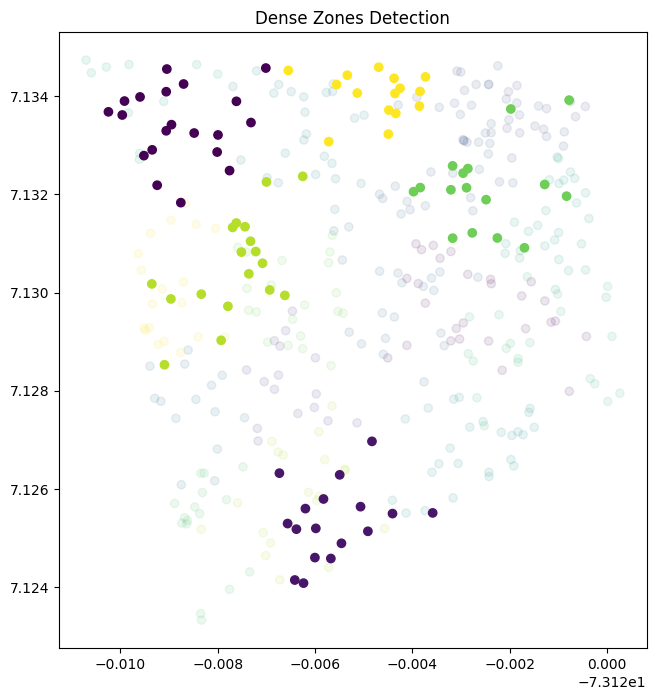

In [36]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax)
plt.title('Dense Zones Detection')
plt.show()



In [37]:
list_centermost = []
for hpc in high_mixp_clusters:
    cluster_series = gdf.loc[gdf.cluster==hpc, ['Latitud', 'Longitud']].squeeze()
    list_centermost.append(get_centermost_point(cluster_series.values))

list_centermost

[(7.133422354505766, -73.12894806256115),
 (7.125194770637045, -73.12598305935552),
 (7.131893637582354, -73.12248669146913),
 (7.130825444753504, -73.12751227058261),
 (7.134058648605138, -73.12435758870895)]

In [39]:
lats, lons = zip(*list_centermost)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points['cluster'] = high_mixp_clusters
rep_points['color'] = rep_points['cluster'].map(color_mapping)
rep_points

,lon,lat,cluster,color
0,-73.128948,7.133422,1,red
1,-73.125983,7.125195,2,blue
2,-73.122487,7.131894,15,salmon
3,-73.127512,7.130825,17,indigo
4,-73.124358,7.134059,19,orchid


In [40]:
crs = {'init': 'epsg:4326'}

geometry = [Point(x, y) for x, y in zip(rep_points['lon'], rep_points['lat'])]

gdf_rep = gpd.GeoDataFrame({'color': rep_points['color'],
                        'cluster': rep_points['cluster'],
                        'Longitud': rep_points['lon'],
                        'Latitud': rep_points['lat'],
                        'geometry': geometry}, crs=crs)



/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


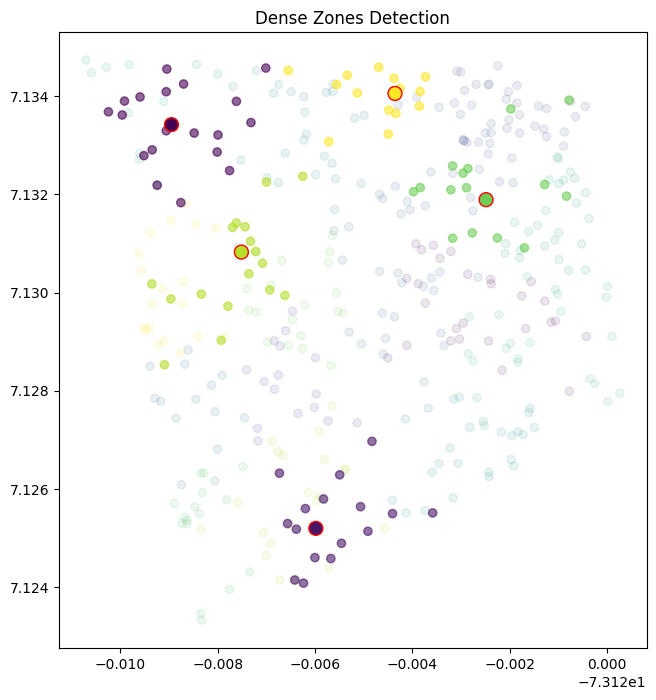

In [41]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax, alpha=0.6)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.title('Dense Zones Detection')
plt.show()

In [42]:
distances = pdist(gdf_rep[['Longitud', 'Latitud']])
th_dist = np.mean(distances) - 2 * (np.std(distances))
th_dist

0.001648971769283229

In [43]:
pairs = create_row_pairs(gdf_rep[['Longitud', 'Latitud', 'cluster']])
pairs

,point1,point2,cluster1,cluster2
0,"[-73.12894806256115, 7.133422354505766]","[-73.12598305935552, 7.125194770637045]",1.0,2.0
1,"[-73.12894806256115, 7.133422354505766]","[-73.12248669146913, 7.131893637582354]",1.0,15.0
2,"[-73.12894806256115, 7.133422354505766]","[-73.12751227058261, 7.130825444753504]",1.0,17.0
3,"[-73.12894806256115, 7.133422354505766]","[-73.12435758870895, 7.134058648605138]",1.0,19.0
4,"[-73.12598305935552, 7.125194770637045]","[-73.12248669146913, 7.131893637582354]",2.0,15.0
5,"[-73.12598305935552, 7.125194770637045]","[-73.12751227058261, 7.130825444753504]",2.0,17.0
6,"[-73.12598305935552, 7.125194770637045]","[-73.12435758870895, 7.134058648605138]",2.0,19.0
7,"[-73.12248669146913, 7.131893637582354]","[-73.12751227058261, 7.130825444753504]",15.0,17.0
8,"[-73.12248669146913, 7.131893637582354]","[-73.12435758870895, 7.134058648605138]",15.0,19.0
9,"[-73.12751227058261, 7.130825444753504]","[-73.12435758870895, 7.134058648605138]",17.0,19.0


In [44]:
def delete_clusters(gdf_rep, pairs, th_dist, high_portfolio_clusters):
    """
    """
    clusters_to_delete = []
    for ind, row in pairs.iterrows():
        dist = euclidean(row.point1, row.point2)
        if dist <= th_dist:
            # una idea seria eliminar el que este menos denso
            clusters_to_delete.append(row.cluster2)

    clusters_to_delete = set(clusters_to_delete)
    high_portfolio_clusters = list(set(high_portfolio_clusters).difference(clusters_to_delete))
    gdf_rep = gdf_rep[~gdf_rep['cluster'].isin(clusters_to_delete)]
    
    return high_portfolio_clusters, gdf_rep

In [45]:
clusters_to_delete = []
for ind, row in pairs.iterrows():
    dist = euclidean(row.point1, row.point2)
    if dist <= th_dist:
        # una idea seria eliminar el que este menos denso
        clusters_to_delete.append(row.cluster2)
    
clusters_to_delete = set(clusters_to_delete)
clusters_to_delete

set()

In [46]:
high_mixp_clusters = list(set(high_mixp_clusters).difference(clusters_to_delete))
high_mixp_clusters

[1, 2, 17, 19, 15]

In [47]:
general_points =  gdf.loc[~gdf.cluster.isin(high_mixp_clusters)]
important_points = gdf.loc[gdf.cluster.isin(high_mixp_clusters)]

In [49]:
gdf_rep = gdf_rep[~gdf_rep['cluster'].isin(clusters_to_delete)]

important_points.groupby('cluster').agg({'mix premium':['median', 'max']})

mix premium      
             median   max
cluster                  
1             0.360  0.50
2             0.360  0.48
15            0.390  0.50
17            0.385  0.50
19            0.360  0.48

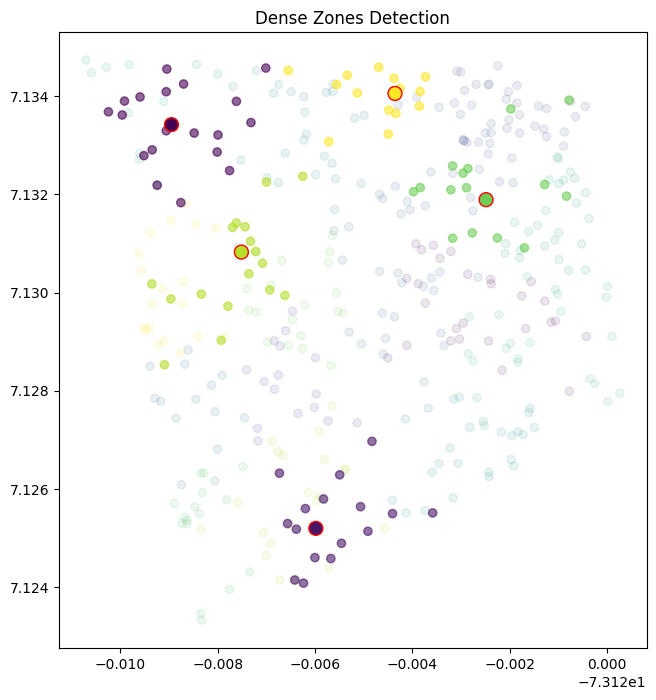

In [50]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax, alpha=0.6)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.title('Dense Zones Detection')
plt.show()

In [51]:
max_mixp_dict = gdf.loc[gdf.cluster.isin(high_mixp_clusters)].groupby('cluster').agg({'mix premium':'median'}).to_dict()['mix premium']
max_mixp_dict

{1: 0.36, 2: 0.36, 15: 0.39, 17: 0.385, 19: 0.36}

In [55]:
gdf_rep = gdf_rep.to_crs(epsg=32618) # 32634 #3857 -... for colombia 17,18,19
gdf = gdf.to_crs(epsg=32618)

gdf_rep.reset_index(drop=True, inplace=True)

In [56]:
# compute scores based on circles
gdf, circle_coors = compute_score_circles_mixp(gdf, gdf_rep, max_mixp_dict, r_meters=250)

In [57]:
gdf['color_score'] = 'blue'
gdf.loc[gdf.score.isna(), 'color_score'] = 'red'

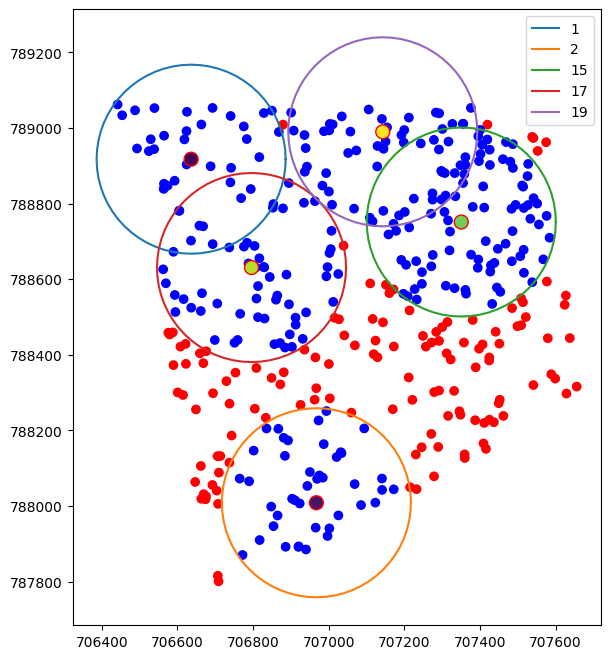

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))

for (x, y), cluster_id in zip(circle_coors, gdf_rep.cluster.values):
    ax.plot(x, y, label=f'{cluster_id}')
    
gdf.plot(c=gdf['color_score'], legend=True,ax=ax)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.legend()
plt.show()

## Portfolio 

### Análisis geoespacial

In [4]:
# no olvidar que antes tenfo que filtrar el año y el mes de interes para portfolio
unique_customers = data.groupby('Codigocliente').agg({'Longitud': 'first', 'Latitud': 'first', 'Portfolio':'first'}).reset_index()
unique_customers

,Codigocliente,Longitud,Latitud,Portfolio
0,C2270,-73.102020,7.079822,6
1,C2271,-73.100412,7.078835,6
2,C2272,-73.107898,7.061582,2
3,C2273,-73.090282,7.078846,8
4,C2274,-73.100675,7.081231,1
...,...,...,...,...
398,C4126,-73.096791,7.078356,4
399,C4127,-73.086916,7.076885,8
400,C4128,-73.095758,7.081231,2
401,C4129,-73.089441,7.076093,4


In [5]:
unique_customers[['Latitud', 'Longitud']] = simulate_coords(point1 = (7.134750, -73.130748), 
                                                            point2 = (7.122850, -73.128298), 
                                                            point3 = (7.127587, -73.119675), 
                                                            point4 = (7.134673, -73.120517),
                                                            num_points=403)

In [6]:
crs = {'init': 'epsg:4326'}

geometry = [Point(x, y) for x, y in zip(unique_customers['Longitud'], unique_customers['Latitud'])]

gdf = gpd.GeoDataFrame({'Codigocliente': unique_customers['Codigocliente'], 
                        'portfolio': unique_customers['Portfolio'],
                        'Longitud': unique_customers['Longitud'],
                        'Latitud': unique_customers['Latitud'],
                        'geometry': geometry}, crs=crs)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Método 1: Kmeans

In [7]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data using the scaler
coords = gdf[['Latitud', 'Longitud', 'portfolio']].values
scaled_coords = scaler.fit_transform(coords)
scaled_coords

array([[0.53970302, 0.63390893, 0.625     ],
       [0.15003537, 0.16846003, 0.625     ],
       [0.7682744 , 0.3709783 , 0.125     ],
       ...,
       [0.25205606, 0.17196418, 0.125     ],
       [0.37098489, 0.23248966, 0.375     ],
       [0.80449156, 0.65385681, 0.5       ]])

#### Hacer el clustering

In [8]:
min_clients_cluster = 20

In [9]:
solver = make_high_portfolio_clusters(method='KMeans', 
                             coords=scaled_coords, 
                             min_clients_cluster=min_clients_cluster, 
                             epsilon=None, metric=None)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
gdf['cluster'] = solver.labels_
np.unique(gdf['cluster'].values, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([20, 23, 28, 16, 28, 29, 17, 19, 20, 17, 19, 23, 18, 15, 20, 21, 13,
        22, 20, 15]))

#### Calcular las metricas por cluster

In [11]:
metrics = gdf.groupby('cluster').agg({'portfolio':['median', 'count']})
metrics.columns = metrics.columns.map('_'.join)
metrics.reset_index(inplace=True)
metrics

,cluster,portfolio_median,portfolio_count
0,0,5.0,20
1,1,7.0,23
2,2,2.0,28
3,3,1.0,16
4,4,8.0,28
5,5,8.0,29
6,6,5.0,17
7,7,2.0,19
8,8,6.0,20
9,9,7.0,17


#### Calcular los cluster con alto portfolio

In [12]:
## los ultimos dos cluster con mas altos numeros en portfolio
high_portfolio = 7#sorted(metrics['portfolio_median'].unique())[-2:]
high_portfolio_clusters = metrics.loc[(metrics.portfolio_count>=min_clients_cluster//3)&
                                     (metrics.portfolio_median>=high_portfolio)].cluster.values

high_portfolio_clusters

array([ 1,  4,  5,  9, 10, 11], dtype=int32)

In [13]:
gdf['color'] = gdf['cluster'].map(color_mapping)

In [14]:
gdf.loc[gdf.cluster.isin(high_portfolio_clusters)]

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color
0,C2270,6,-73.123858,7.129304,POINT (-73.12386 7.12930),9,grey
3,C2273,8,-73.130132,7.134699,POINT (-73.13013 7.13470),4,purple
6,C2276,7,-73.125177,7.133349,POINT (-73.12518 7.13335),10,yellow
8,C2278,7,-73.122960,7.126978,POINT (-73.12296 7.12698),9,grey
9,C2279,6,-73.122497,7.126074,POINT (-73.12250 7.12607),9,grey
...,...,...,...,...,...,...,...
387,C4115,9,-73.124017,7.129154,POINT (-73.12402 7.12915),11,olive
388,C4116,9,-73.126900,7.125163,POINT (-73.12690 7.12516),5,orange
389,C4117,8,-73.125349,7.129468,POINT (-73.12535 7.12947),11,olive
396,C4124,9,-73.123286,7.126664,POINT (-73.12329 7.12666),11,olive


In [15]:
general_points =  gdf.loc[~gdf.cluster.isin(high_portfolio_clusters)]
important_points = gdf.loc[gdf.cluster.isin(high_portfolio_clusters)]

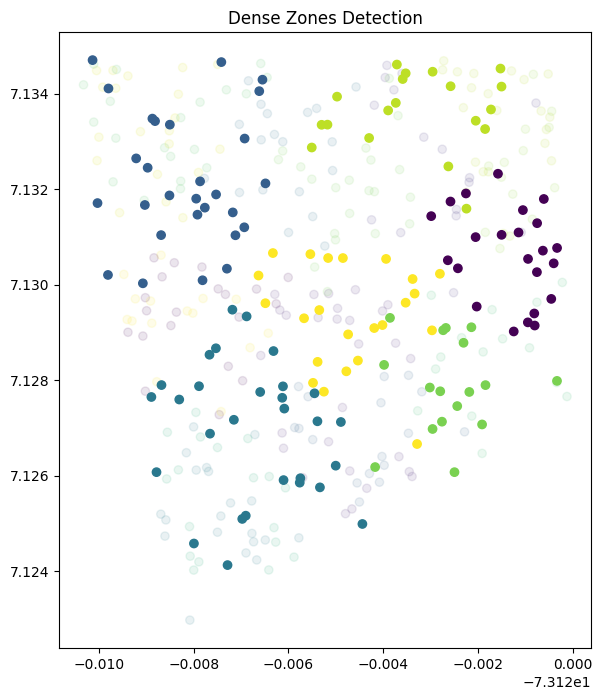

In [16]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax)
plt.title('Dense Zones Detection')
plt.show()

#### Calcular los puntos referentes en el cluster

In [17]:
list_centermost = []
for hpc in high_portfolio_clusters:
    cluster_series = gdf.loc[gdf.cluster==hpc, ['Latitud', 'Longitud']].squeeze()
    list_centermost.append(get_centermost_point(cluster_series.values))

list_centermost

[(7.130537654933624, -73.12094588136833),
 (7.1321611963768685, -73.12786406548042),
 (7.127170652487638, -73.12715094964202),
 (7.1277673485863735, -73.12279768317201),
 (7.133804139580089, -73.1237348521861),
 (7.128958264802989, -73.12474082908791)]

In [18]:
lats, lons = zip(*list_centermost)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points['cluster'] = high_portfolio_clusters
rep_points['color'] = rep_points['cluster'].map(color_mapping)
rep_points

,lon,lat,cluster,color
0,-73.120946,7.130538,1,red
1,-73.127864,7.132161,4,purple
2,-73.127151,7.127171,5,orange
3,-73.122798,7.127767,9,grey
4,-73.123735,7.133804,10,yellow
5,-73.124741,7.128958,11,olive


In [19]:
crs = {'init': 'epsg:4326'}

geometry = [Point(x, y) for x, y in zip(rep_points['lon'], rep_points['lat'])]

gdf_rep = gpd.GeoDataFrame({'color': rep_points['color'],
                        'cluster': rep_points['cluster'],
                        'Longitud': rep_points['lon'],
                        'Latitud': rep_points['lat'],
                        'geometry': geometry}, crs=crs)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


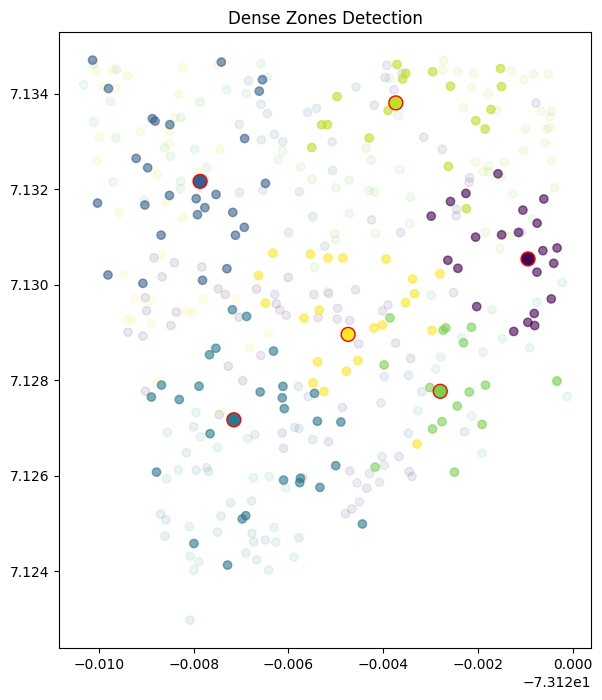

In [20]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax, alpha=0.6)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.title('Dense Zones Detection')
plt.show()

#### Mejorar Clusters: Eliminar clusters cerca y muy amplios

In [21]:
distances = pdist(gdf_rep[['Longitud', 'Latitud']])
th_dist = np.mean(distances) - 2 * (np.std(distances))
th_dist

0.001915935036350336

In [22]:
pairs = create_row_pairs(gdf_rep[['Longitud', 'Latitud', 'cluster']])
pairs

,point1,point2,cluster1,cluster2
0,"[-73.12094588136833, 7.130537654933624]","[-73.12786406548042, 7.1321611963768685]",1.0,4.0
1,"[-73.12094588136833, 7.130537654933624]","[-73.12715094964202, 7.127170652487638]",1.0,5.0
2,"[-73.12094588136833, 7.130537654933624]","[-73.12279768317201, 7.1277673485863735]",1.0,9.0
3,"[-73.12094588136833, 7.130537654933624]","[-73.1237348521861, 7.133804139580089]",1.0,10.0
4,"[-73.12094588136833, 7.130537654933624]","[-73.12474082908791, 7.128958264802989]",1.0,11.0
5,"[-73.12786406548042, 7.1321611963768685]","[-73.12715094964202, 7.127170652487638]",4.0,5.0
6,"[-73.12786406548042, 7.1321611963768685]","[-73.12279768317201, 7.1277673485863735]",4.0,9.0
7,"[-73.12786406548042, 7.1321611963768685]","[-73.1237348521861, 7.133804139580089]",4.0,10.0
8,"[-73.12786406548042, 7.1321611963768685]","[-73.12474082908791, 7.128958264802989]",4.0,11.0
9,"[-73.12715094964202, 7.127170652487638]","[-73.12279768317201, 7.1277673485863735]",5.0,9.0


In [52]:
def delete_clusters(gdf_rep, pairs, th_dist):
    """
    """
    clusters_to_delete = []
    for ind, row in pairs.iterrows():
        dist = euclidean(row.point1, row.point2)
        if dist <= th_dist:
            # una idea seria eliminar el que este menos denso
            clusters_to_delete.append(row.cluster2)

    clusters_to_delete = set(clusters_to_delete)
    high_portfolio_clusters = list(set(high_portfolio_clusters).difference(clusters_to_delete))
    gdf_rep = gdf_rep[~gdf_rep['cluster'].isin(clusters_to_delete)]
    
    return high_portfolio_clusters, gdf_rep

In [23]:
clusters_to_delete = []
for ind, row in pairs.iterrows():
    dist = euclidean(row.point1, row.point2)
    if dist <= th_dist:
        # una idea seria eliminar el que este menos denso
        clusters_to_delete.append(row.cluster2)
    
clusters_to_delete = set(clusters_to_delete)
clusters_to_delete

set()

In [24]:
high_portfolio_clusters = list(set(high_portfolio_clusters).difference(clusters_to_delete))
high_portfolio_clusters

[1, 4, 5, 9, 10, 11]

In [25]:
general_points =  gdf.loc[~gdf.cluster.isin(high_portfolio_clusters)]
important_points = gdf.loc[gdf.cluster.isin(high_portfolio_clusters)]

In [26]:
gdf_rep = gdf_rep[~gdf_rep['cluster'].isin(clusters_to_delete)]

In [27]:
important_points.groupby('cluster').agg({'portfolio':['median', 'max']})

portfolio    
           median max
cluster              
1             7.0   9
4             8.0   9
5             8.0   9
9             7.0   8
10            8.0   9
11            9.0   9

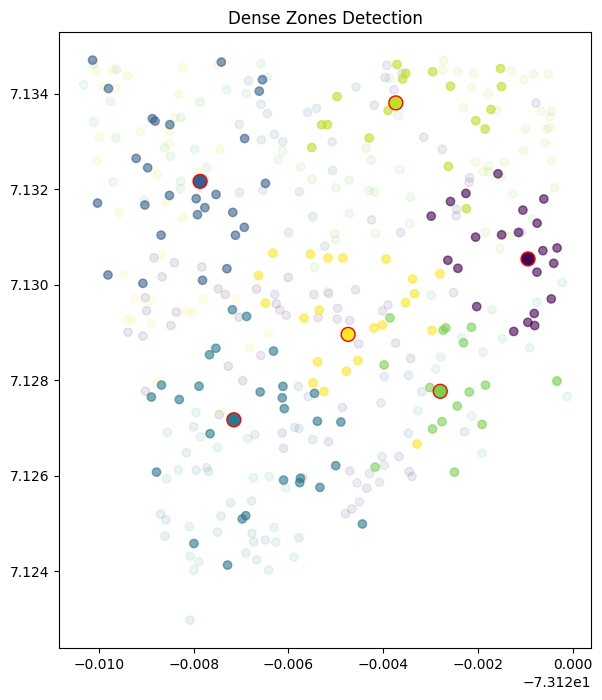

In [28]:
# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
general_points.plot(column='cluster', c=general_points['color'], legend=False, ax=ax, alpha=0.1)
important_points.plot(column='cluster', c=important_points['color'], legend=False, ax=ax, alpha=0.6)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.title('Dense Zones Detection')
plt.show()

In [29]:
gdf

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color
0,C2270,6,-73.123858,7.129304,POINT (-73.12386 7.12930),9,grey
1,C2271,6,-73.128605,7.124736,POINT (-73.12860 7.12474),8,pink
2,C2272,2,-73.126539,7.131983,POINT (-73.12654 7.13198),7,brown
3,C2273,8,-73.130132,7.134699,POINT (-73.13013 7.13470),4,purple
4,C2274,1,-73.120223,7.130046,POINT (-73.12022 7.13005),13,magenta
...,...,...,...,...,...,...,...
398,C4126,4,-73.124080,7.125865,POINT (-73.12408 7.12586),6,cyan
399,C4127,8,-73.125762,7.125855,POINT (-73.12576 7.12585),5,orange
400,C4128,2,-73.128569,7.125932,POINT (-73.12857 7.12593),12,navy
401,C4129,4,-73.127952,7.127326,POINT (-73.12795 7.12733),12,navy


In [30]:
gdf_rep

,color,cluster,Longitud,Latitud,geometry
0,red,1,-73.120946,7.130538,POINT (-73.12095 7.13054)
1,purple,4,-73.127864,7.132161,POINT (-73.12786 7.13216)
2,orange,5,-73.127151,7.127171,POINT (-73.12715 7.12717)
3,grey,9,-73.122798,7.127767,POINT (-73.12280 7.12777)
4,yellow,10,-73.123735,7.133804,POINT (-73.12373 7.13380)
5,olive,11,-73.124741,7.128958,POINT (-73.12474 7.12896)


In [31]:
gdf_rep = gdf_rep.to_crs(epsg=32618) # 32634 #3857 -... for colombia 17,18,19
gdf = gdf.to_crs(epsg=32618)

In [32]:
gdf_rep.reset_index(drop=True, inplace=True)

In [33]:
gdf

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color
0,C2270,6,-73.123858,7.129304,POINT (707200.396 788464.133),9,grey
1,C2271,6,-73.128605,7.124736,POINT (706678.016 787956.805),8,pink
2,C2272,2,-73.126539,7.131983,POINT (706902.945 788759.269),7,brown
3,C2273,8,-73.130132,7.134699,POINT (706504.825 789058.088),4,purple
4,C2274,1,-73.120223,7.130046,POINT (707601.638 788547.837),13,magenta
...,...,...,...,...,...,...,...
398,C4126,4,-73.124080,7.125865,POINT (707177.394 788083.667),6,cyan
399,C4127,8,-73.125762,7.125855,POINT (706991.608 788081.802),5,orange
400,C4128,2,-73.128569,7.125932,POINT (706681.428 788089.089),12,navy
401,C4129,4,-73.127952,7.127326,POINT (706748.998 788243.555),12,navy


In [38]:
max_portfolio_dict = gdf.loc[gdf.cluster.isin(high_portfolio_clusters)].groupby('cluster').agg({'portfolio':'median'}).to_dict()['portfolio']

# compute scores based on circles
gdf, circle_coors = compute_score_circles(gdf, gdf_rep, max_portfolio_dict, r_meters=250)


In [39]:
gdf['color_score'] = 'blue'
gdf.loc[gdf.score.isna(), 'color_score'] = 'red'

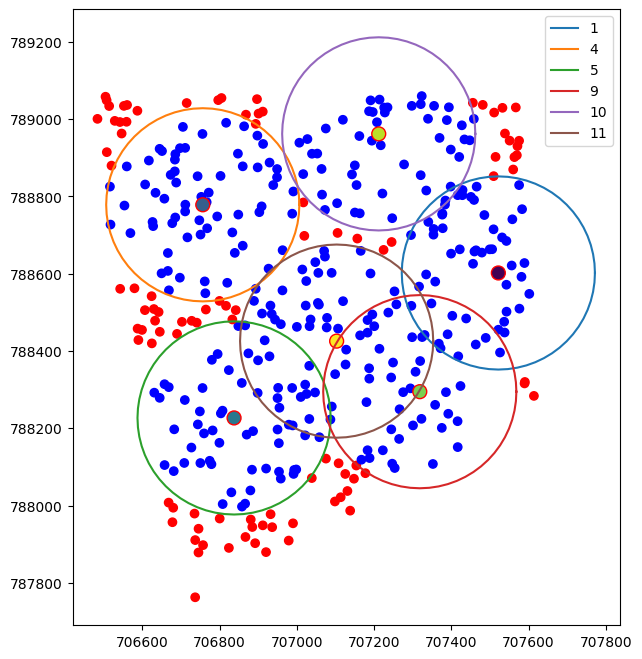

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

for (x, y), cluster_id in zip(circle_coors, gdf_rep.cluster.values):
    ax.plot(x, y, label=f'{cluster_id}')
    
gdf.plot(c=gdf['color_score'], legend=True,ax=ax)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.legend()
plt.show()

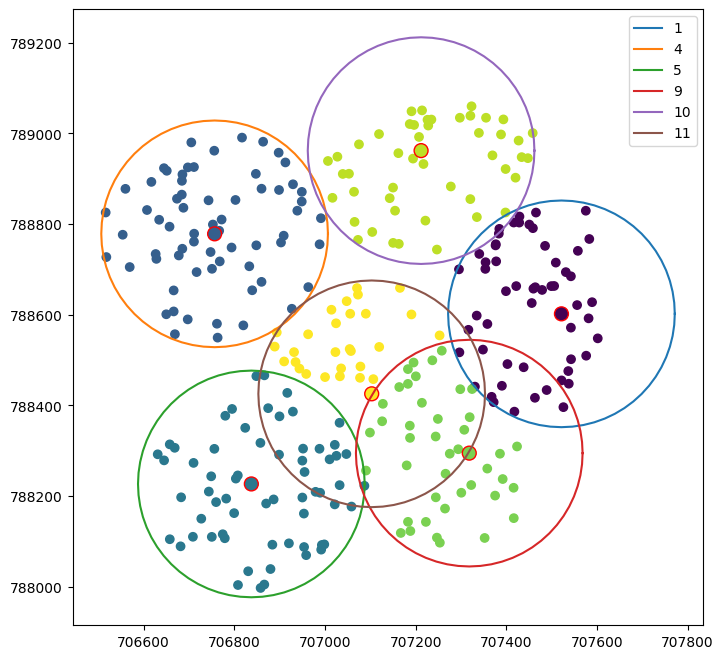

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

for (x, y), cluster_id in zip(circle_coors, gdf_rep.cluster.values):
    ax.plot(x, y, label=f'{cluster_id}')
    
gdf.plot(c=gdf['new_cluster'], legend=True,ax=ax)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.legend()
plt.show()

#### Asignar cluster y calcular score para los que quedaron fuera

In [43]:
result_df = assign_cluster_to_missing_scores(customers_gdf=gdf, centroids_gdf=gdf_rep)

/media/jefferson/8d9ac032-5177-4033-ab7f-c336bbd6f959/Personal_projects/visitor_allocator/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
gdf = gdf.merge(result_df[['Codigocliente', 'new_cluster']], on='Codigocliente',  how='left', validate='1:1')
gdf

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color,score,new_cluster_x,color_score,new_cluster_y
0,C2270,6,-73.123858,7.129304,POINT (707200.396 788464.133),9,grey,0.142857,9.0,blue,NaN
1,C2271,6,-73.128605,7.124736,POINT (706678.016 787956.805),8,pink,NaN,NaN,red,5.0
2,C2272,2,-73.126539,7.131983,POINT (706902.945 788759.269),7,brown,0.750000,4.0,blue,NaN
3,C2273,8,-73.130132,7.134699,POINT (706504.825 789058.088),4,purple,NaN,NaN,red,4.0
4,C2274,1,-73.120223,7.130046,POINT (707601.638 788547.837),13,magenta,0.857143,1.0,blue,NaN
...,...,...,...,...,...,...,...,...,...,...,...
398,C4126,4,-73.124080,7.125865,POINT (707177.394 788083.667),6,cyan,NaN,NaN,red,9.0
399,C4127,8,-73.125762,7.125855,POINT (706991.608 788081.802),5,orange,0.000000,5.0,blue,NaN
400,C4128,2,-73.128569,7.125932,POINT (706681.428 788089.089),12,navy,0.750000,5.0,blue,NaN
401,C4129,4,-73.127952,7.127326,POINT (706748.998 788243.555),12,navy,0.500000,5.0,blue,NaN


In [45]:
gdf['new_cluster'] = gdf['new_cluster_x'].combine_first(gdf['new_cluster_y'])
# Drop the unnecessary columns
gdf = gdf.drop(['new_cluster_x', 'new_cluster_y'], axis=1)
gdf

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color,score,color_score,new_cluster
0,C2270,6,-73.123858,7.129304,POINT (707200.396 788464.133),9,grey,0.142857,blue,9.0
1,C2271,6,-73.128605,7.124736,POINT (706678.016 787956.805),8,pink,NaN,red,5.0
2,C2272,2,-73.126539,7.131983,POINT (706902.945 788759.269),7,brown,0.750000,blue,4.0
3,C2273,8,-73.130132,7.134699,POINT (706504.825 789058.088),4,purple,NaN,red,4.0
4,C2274,1,-73.120223,7.130046,POINT (707601.638 788547.837),13,magenta,0.857143,blue,1.0
...,...,...,...,...,...,...,...,...,...,...
398,C4126,4,-73.124080,7.125865,POINT (707177.394 788083.667),6,cyan,NaN,red,9.0
399,C4127,8,-73.125762,7.125855,POINT (706991.608 788081.802),5,orange,0.000000,blue,5.0
400,C4128,2,-73.128569,7.125932,POINT (706681.428 788089.089),12,navy,0.750000,blue,5.0
401,C4129,4,-73.127952,7.127326,POINT (706748.998 788243.555),12,navy,0.500000,blue,5.0


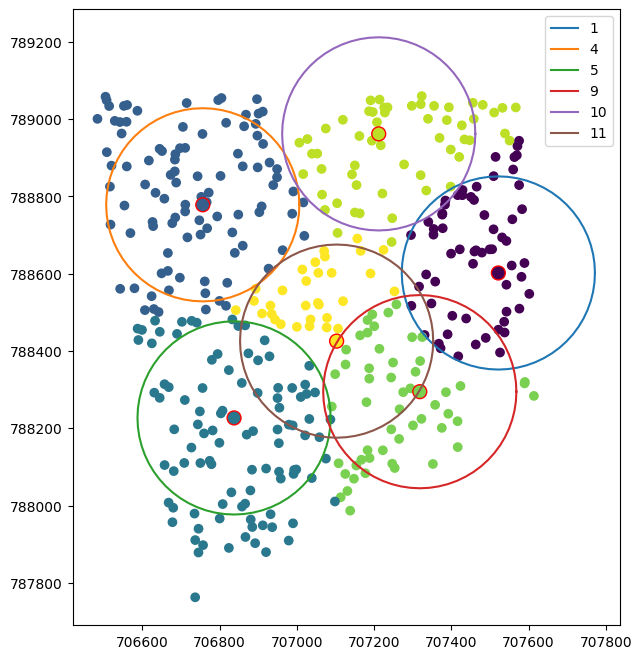

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

for (x, y), cluster_id in zip(circle_coors, gdf_rep.cluster.values):
    ax.plot(x, y, label=f'{cluster_id}')
    
gdf.plot(c=gdf['new_cluster'], legend=True,ax=ax)
gdf_rep.plot(column='cluster', c=gdf_rep['color'], legend=False, s=100, ax=ax, alpha=1, edgecolor='red')

plt.legend()
plt.show()

#### Generar Score

In [47]:
gdf.loc[gdf.score.isna()]

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color,score,color_score,new_cluster
1,C2271,6,-73.128605,7.124736,POINT (706678.016 787956.805),8,pink,NaN,red,5.0
3,C2273,8,-73.130132,7.134699,POINT (706504.825 789058.088),4,purple,NaN,red,4.0
5,C2275,5,-73.128992,7.129453,POINT (706633.072 788478.325),0,darkolivegreen,NaN,red,5.0
15,C2285,1,-73.129917,7.134133,POINT (706528.775 788995.595),18,gold,NaN,red,4.0
19,C2289,7,-73.130323,7.134182,POINT (706483.975 789000.802),14,teal,NaN,red,4.0
...,...,...,...,...,...,...,...,...,...,...
385,C4113,6,-73.129070,7.128923,POINT (706624.704 788419.709),0,darkolivegreen,NaN,red,5.0
386,C4114,3,-73.120447,7.133629,POINT (707575.246 788944.099),16,lime,NaN,red,1.0
391,C4119,5,-73.128363,7.129424,POINT (706702.599 788475.428),0,darkolivegreen,NaN,red,5.0
395,C4123,5,-73.125780,7.124699,POINT (706990.084 787953.984),8,pink,NaN,red,5.0


In [48]:
missing_scores = gdf.loc[gdf.score.isna()].apply(lambda x: generate_score(max_portfolio_dict[int(x.new_cluster)], x.portfolio), axis=1)

In [49]:
gdf.loc[gdf.score.isna(), 'score'] = missing_scores

In [50]:
gdf

,Codigocliente,portfolio,Longitud,Latitud,geometry,cluster,color,score,color_score,new_cluster
0,C2270,6,-73.123858,7.129304,POINT (707200.396 788464.133),9,grey,0.142857,blue,9.0
1,C2271,6,-73.128605,7.124736,POINT (706678.016 787956.805),8,pink,0.250000,red,5.0
2,C2272,2,-73.126539,7.131983,POINT (706902.945 788759.269),7,brown,0.750000,blue,4.0
3,C2273,8,-73.130132,7.134699,POINT (706504.825 789058.088),4,purple,0.000000,red,4.0
4,C2274,1,-73.120223,7.130046,POINT (707601.638 788547.837),13,magenta,0.857143,blue,1.0
...,...,...,...,...,...,...,...,...,...,...
398,C4126,4,-73.124080,7.125865,POINT (707177.394 788083.667),6,cyan,0.428571,red,9.0
399,C4127,8,-73.125762,7.125855,POINT (706991.608 788081.802),5,orange,0.000000,blue,5.0
400,C4128,2,-73.128569,7.125932,POINT (706681.428 788089.089),12,navy,0.750000,blue,5.0
401,C4129,4,-73.127952,7.127326,POINT (706748.998 788243.555),12,navy,0.500000,blue,5.0


In [51]:
#gdf_rep = gdf_rep.to_crs(epsg=4326) # 32634 #3857 -... for colombia 17,18,19
#gdf = gdf.to_crs(epsg=4326)

## DBSCAN

In [664]:
#distances = pdist(coords, equirectangular_approximation)
distances = pdist(scaled_coords)

np.mean(distances), np.median(distances), np.std(distances)

median_distance = np.median(distances)
median_distance

#kms_per_radian = 6371.0088
#epsilon = median_distance / kms_per_radian
#epsilon = median_distance
epsilon = median_distance/9

epsilon

0.04258238293482968

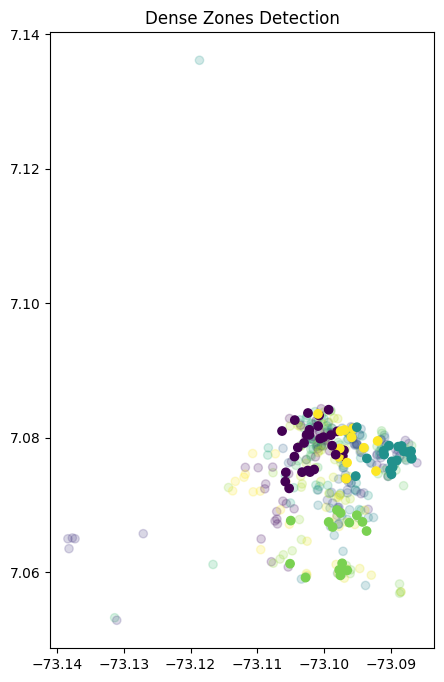